# Topic modeling on scientific literature

In [1]:
import os
import re 

import pdftotext

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14, "font.family": "Times"})

import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import networkx as nx


PDF_FOLDER = './data/pdf'
MASK_IMAGE_PATH = './images/cloud.png'
OUTPUT_FOLDER = './outputs'

N_TOPICS = 6
N_WORDS_PER_TOPIC = 50
N_WORDS_HIGHLIGHT_WORDCLOUD = 5
OCCURRENCE_THRESHOLD = 0.1

with open('./utils/stop_words_EN.txt', 'r') as f:
    STOP_WORDS = f.read().split('\n')

In [2]:
# Utility functions

def get_topic_words(pipe, top_n_words=15):
    t_words, word_strengths = {}, {}
    tdidf_features = pipe.named_steps['tfidf'].get_feature_names_out()
    for t_id, t in enumerate(pipe.named_steps['topic_model'].components_):
        t_words[t_id] = [tdidf_features[i] for i in t.argsort()[:-top_n_words - 1:-1]]
        word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
    return t_words, word_strengths

def wordcloud(topic_i_word_importances, keywords, ax, plot_title=False):
    # Generate mask based on image
    mask = np.array(Image.open(MASK_IMAGE_PATH))
    mask = np.where(mask>220, 255, mask)
    image_colors = ImageColorGenerator(mask)

    # Func to highlight keyword
    def keyword_colorize(word, font_size, position, orientation, random_state=None,
                        **kwargs):
        if word in keywords:
            return "rgb(0, 0, 255)"
        else:
            return image_colors(word=word, font_size=font_size, position=position, 
                                orientation=orientation, random_state=None, **kwargs) 

    # Generate word cloud object
    wc = WordCloud(background_color="white", max_words=100, mask=mask)
    wc.generate_from_frequencies(topic_i_word_importances)

    # Plot image
    ax.imshow(wc.recolor(color_func=keyword_colorize), interpolation="bilinear")
    ax.axis("off") # remove axis 
    if plot_title:
        ax.set_title(plot_title, fontsize=18)

## Load documents

In [3]:
documents = []
# Load your PDFs
for f in os.listdir(PDF_FOLDER):
    d = ''
    with open(os.path.join(PDF_FOLDER, f), "rb") as filename:
        try:
            pdf = pdftotext.PDF(filename)
            for i in pdf:
                d += i + '\n\n'
            documents.append(d)
        except:
            print('Not able to use pdftotext: ', f)
    
print('PDFs loaded as text.')

Not able to transform pdftotext:  README.md
PDFs loaded as text.


In [4]:
years = []
for f in os.listdir(PDF_FOLDER):
    _ = re.findall(r"(20\d{2})", f)
    if len(_)>=1:
        years.append(_[0])

## Preprocessing

In [5]:
nlp = spacy.load("en_core_web_sm")

docs = []

for doc in nlp.pipe(documents):
    filtered = ' '.join([token.lemma_ for token in doc if token.pos_ in ['ADJ', 'VERB', 'NOUN', 'PROPN']])
    docs.append(filtered)

## Topic model

In [6]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.95, min_df=2,
                              max_features=2000,
                              stop_words=STOP_WORDS,
                              ngram_range=(1, 3))),
    ('topic_model', NMF(N_TOPICS, 
                        max_iter=1000))
])

In [7]:
pipe.fit(docs)

/Users/adelsondias/miniconda3/envs/ca-prototype/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=2000, min_df=2,
                                 ngram_range=(1, 3),
                                 stop_words=['ll', 'tis', 'twas', 've', '000',
                                             '00', 'a', 'as', 'able',
                                             'ableabout', 'about', 'above',
                                             'abroad', 'abst', 'accordance',
                                             'according', 'accordingly',
                                             'across', 'act', 'actually', 'ad',
                                             'added', 'adj', 'adopted', 'ae',
                                             'af', 'affected', 'affecting',
                                             'affects', 'after', ...])),
                ('topic_model', NMF(max_iter=1000, n_components=6))])

## Analysis

### a. What are some prominent topics in the literature?

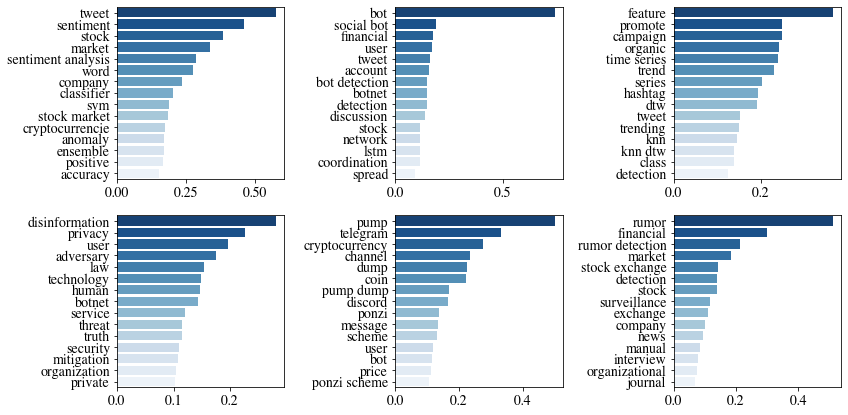

In [8]:
topic_words, words_importance = get_topic_words(pipe, 15)

nrows = int(np.ceil(N_TOPICS/3))
fig, ax = plt.subplots(figsize=(12,3*nrows), ncols=3, nrows=nrows)

plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)

c=0
for row in range(0, nrows):
    for col in range(0,3):
        
        try:
            sns.barplot(x=words_importance[c], y=topic_words[c], palette="Blues_r", ax=ax[row][col])
        except:
            pass
        c+=1
        if c>N_TOPICS:
            ax[row][col].axis('off')
        
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FOLDER, 'topics_barplot.png'), facecolor='#fff', dpi=300) 
plt.show()

In [9]:
topic_words, words_importance = get_topic_words(pipe, N_WORDS_PER_TOPIC)

tw = pd.DataFrame(topic_words).melt(var_name='topic_id', value_name='word')
wi = pd.DataFrame(words_importance).melt(var_name='topic_id', value_name='importance')

topic_word_importance = pd.concat([tw,wi['importance']], axis=1)
topic_word_importance = topic_word_importance.set_index(['topic_id', 'word'])
topic_word_importance.sample(5)

importance
topic_id word                       
1        account level      0.055592
         online             0.073296
5        rumor detection    0.212466
3        attack             0.087621
4        conf               0.062659

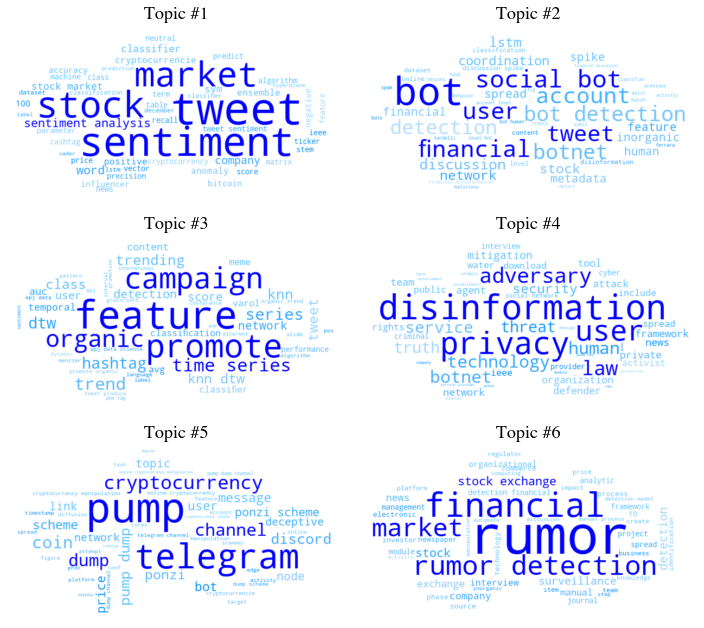

In [10]:
nrows = int(np.ceil(N_TOPICS/2))
fig, ax = plt.subplots(figsize=(10,3*nrows), ncols=2, nrows=nrows)

c=0
for row in range(0, nrows):
    for col in range(0,2):
        topic_i_word_importances = topic_word_importance.loc[c, 'importance']
        wordcloud(topic_i_word_importances.to_dict(), 
                  keywords=topic_i_word_importances.sort_values()[-N_WORDS_HIGHLIGHT_WORDCLOUD:], 
                  ax=ax[row][col],
                  plot_title=f'Topic #{c+1}')
        c+=1
        if c>N_TOPICS:
            ax[row][col].axis('off')
                
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_FOLDER, 'wordcloud.png'), facecolor='#fff', dpi=300) 
plt.show()

In [11]:
docs_topics = pd.DataFrame(pipe.transform(docs), columns=list(range(1,N_TOPICS+1)))
docs_topics

,1,2,3,4,5,6
0,0.000000,0.045597,0.000000,0.000000,0.837590,0.000000
1,0.035369,0.506794,0.199291,0.000000,0.010853,0.226436
2,0.000000,0.020263,0.868368,0.007082,0.000123,0.028367
3,0.470861,0.000000,0.000000,0.014478,0.030676,0.000000
4,0.002902,0.242081,0.064392,0.173470,0.124252,0.111325
5,0.379390,0.043546,0.000000,0.000000,0.071813,0.104022
6,0.399836,0.000000,0.169541,0.000000,0.000000,0.011578
7,0.068301,0.000000,0.007364,0.018183,0.811813,0.000000
8,0.508001,0.000000,0.000000,0.057274,0.000000,0.047232
9,0.000000,0.000000,0.876885,0.000000,0.000000,0.000000


### b. How those themes are connected to each other?

In [12]:
co_occurrences = np.zeros([N_TOPICS, N_TOPICS])

for ix, o in (docs_topics>OCCURRENCE_THRESHOLD).iterrows():
    for i in range(1, N_TOPICS+1):
        for j in range(1, N_TOPICS+1):
            if i!=j and o[i] and o[j]:
                co_occurrences[i-1][j-1] += 1

co_occurrences = pd.DataFrame(co_occurrences, 
                              index=list(range(1,N_TOPICS+1)),
                              columns=list(range(1,N_TOPICS+1)))

co_occurrences

,1,2,3,4,5,6
1,0.0,0.0,2.0,1.0,0.0,1.0
2,0.0,0.0,1.0,2.0,1.0,2.0
3,2.0,1.0,0.0,1.0,0.0,1.0
4,1.0,2.0,1.0,0.0,1.0,1.0
5,0.0,1.0,0.0,1.0,0.0,1.0
6,1.0,2.0,1.0,1.0,1.0,0.0


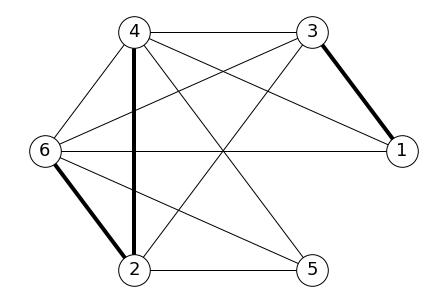

In [13]:
G = nx.Graph()
for ix, i in co_occurrences.iterrows():
    for jx, val in i.iteritems():
        if val>0:
            G.add_edge(ix, jx,color='black',weight=val**2)

pos = nx.circular_layout(G)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, edge_color=colors, width=weights, with_labels=True, 
        node_color="white", edgecolors= "black",
       font_size=18,
       node_size=1000)

### c. How frequent those themes were addressed over time?

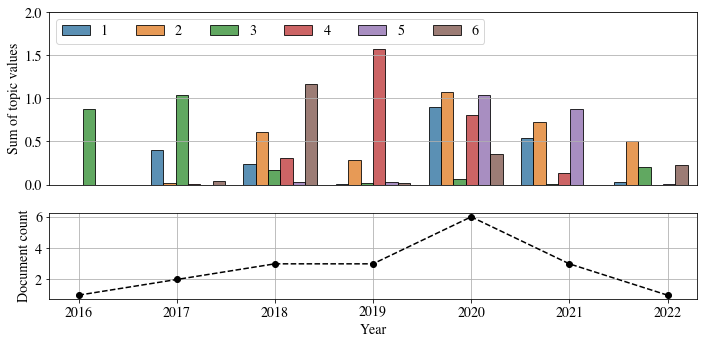

In [19]:
docs_topics2 = docs_topics.melt(var_name='Topic', value_name='Topic value')

docs_topics2['Year'] = years*N_TOPICS

fig, ax = plt.subplots(nrows=2, figsize=(10,5),
                       gridspec_kw={'height_ratios': [2, 1]})

docs_topics3 = docs_topics2.groupby(['Topic', 'Year']).sum().reset_index()
sns.barplot(data=docs_topics3, y='Topic value', x='Year', hue='Topic', 
            ax=ax[0], alpha=.8, edgecolor='black',
            order=['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_ylim([0, 2])
ax[0].set_ylabel('Sum of topic values')

pd.Series(years).value_counts().sort_index().plot(ax=ax[1], color='black', linestyle='--', marker='o')

ax[0].legend(ncol=6, loc='upper left')
ax[0].grid()
ax[1].grid()
ax[1].set_ylabel('Document count')
ax[1].set_xlabel('Year')

fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_FOLDER, 'topics_over_time.png'), dpi=300)